In [53]:
from itertools import product
import pandas as pd
import seaborn as sns

## Recovery with addm.tooldbox.ddm_pta_test

In [9]:
from __future__ import absolute_import, division

import pkg_resources

from builtins import range, str

from addm_toolbox.ddm import DDMTrial, DDM
from addm_toolbox.util import load_trial_conditions_from_csv

In [46]:
d = .006
sigma = .08
rangeD = [0.005, 0.006, 0.007]
rangeSigma = [0.065, 0.08, 0.095]
trialsFileName=None
trialsPerCondition=100 #initially used 800; prob should be >100 for any real fitting
numThreads = 9
verbose = False

In [14]:
# Load trial conditions.
if not trialsFileName:
    trialsFileName = pkg_resources.resource_filename(
        u"addm_toolbox", u"test_data/test_trial_conditions.csv")
trialConditions = load_trial_conditions_from_csv(trialsFileName)

# Generate artificial data.
model = DDM(d, sigma)
trials = list()
for (valueLeft, valueRight) in trialConditions:
    for t in range(trialsPerCondition):
        try:
            trials.append(model.simulate_trial(valueLeft, valueRight))
        except:
            print(u"An exception occurred while generating artificial "
                  "trial " + str(t) + u" for condition (" +
                  str(valueLeft) + u", " + str(valueRight) + u").")
            raise

# Get likelihoods for all models and all artificial trials.
numModels = len(rangeD) * len(rangeSigma)
likelihoods = dict()
models = list()
posteriors = dict()
for d in rangeD:
    for sigma in rangeSigma:
        model = DDM(d, sigma)
        if verbose:
            print(u"Computing likelihoods for model " + str(model.params) +
                  u"...")
        try:
            likelihoods[model.params] = model.parallel_get_likelihoods(
                trials, numThreads=numThreads)
        except:
            print(u"An exception occurred during the likelihood "
                  "computations for model " + str(model.params) + u".")
            raise
        models.append(model)
        posteriors[model.params] = 1 / numModels

# Compute the posteriors.
for t in range(len(trials)):oo
    # Get the denominator for normalizing the posteriors.
    denominator = 0
    for model in models:
        denominator += (posteriors[model.params] *
                        likelihoods[model.params][t])
    if denominator == 0:
        continue

    # Calculate the posteriors after this trial.
    for model in models:
        prior = posteriors[model.params]
        posteriors[model.params] = (likelihoods[model.params][t] *
            prior / denominator)

if verbose:
    for model in models:
        print(u"P" + str(model.params) +  u" = " +
              str(posteriors[model.params]))
    print(u"Sum: " + str(sum(list(posteriors.values()))))

What do the sum of the likelihoods for all 8000 (800 trials per condition for 10 conditions) look like for each parameter combination?

Do the true parameters (d = .006, sigma = .08) have the highest likelihood? No.

In [58]:
df = pd.DataFrame(list(product(rangeD, rangeSigma)), columns=['d', 'sigma'])
df['likelihood'] = [sum(likelihoods[k]) for k in likelihoods.keys()]
df

,d,sigma,likelihood
0,0.005,0.065,29.796591
1,0.005,0.080,31.050708
2,0.005,0.095,31.287604
3,0.006,0.065,33.238956
4,0.006,0.080,33.796666
5,0.006,0.095,33.464963
6,0.007,0.065,36.080859
7,0.007,0.080,36.074872
8,0.007,0.095,35.284419


Likelihood surface heatmap

<AxesSubplot:xlabel='sigma', ylabel='d'>

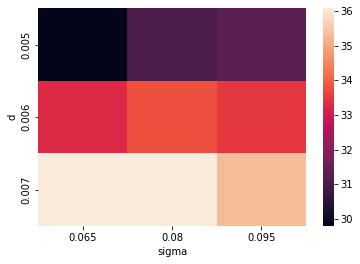

In [60]:
df = df.pivot(index = 'd', columns = 'sigma', values = 'likelihood')
sns.heatmap(df)

What do the posteriors look like?

Is the posterior higghest for the correct parameter combination? (d = 0.006, sigma = .08)

In [79]:
df = pd.DataFrame(list(product(rangeD, rangeSigma)), columns=['d', 'sigma'])
df['posterior'] = [posteriors[k] for k in posteriors.keys()]
df

,d,sigma,posterior
0,0.005,0.065,0.000000e+00
1,0.005,0.080,9.886675e-32
2,0.005,0.095,5.734182e-283
3,0.006,0.065,0.000000e+00
4,0.006,0.080,1.000000e+00
5,0.006,0.095,1.232338e-254
6,0.007,0.065,0.000000e+00
7,0.007,0.080,7.840251e-57
8,0.007,0.095,9.131088e-288


<AxesSubplot:xlabel='sigma', ylabel='d'>

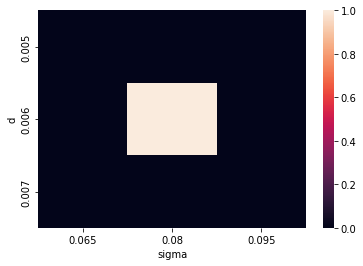

In [80]:
df = df.pivot(index = 'd', columns = 'sigma', values = 'posterior')
sns.heatmap(df)